In [1]:
!pip install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=14869b396569f858309e98db72d2b2fb5583abc7a5e80cad5c296fc9ce79f3aa
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [2]:
import import_ipynb
import pandas as pd
import numpy as np
from pre_functions import *
from collections import OrderedDict

importing Jupyter notebook from pre_functions.ipynb


# 역전파 구현
- 수치미분에 비해서 훨씬 바른 속도로 계산된다 
- 가중치 개수가 많아도 좋다.

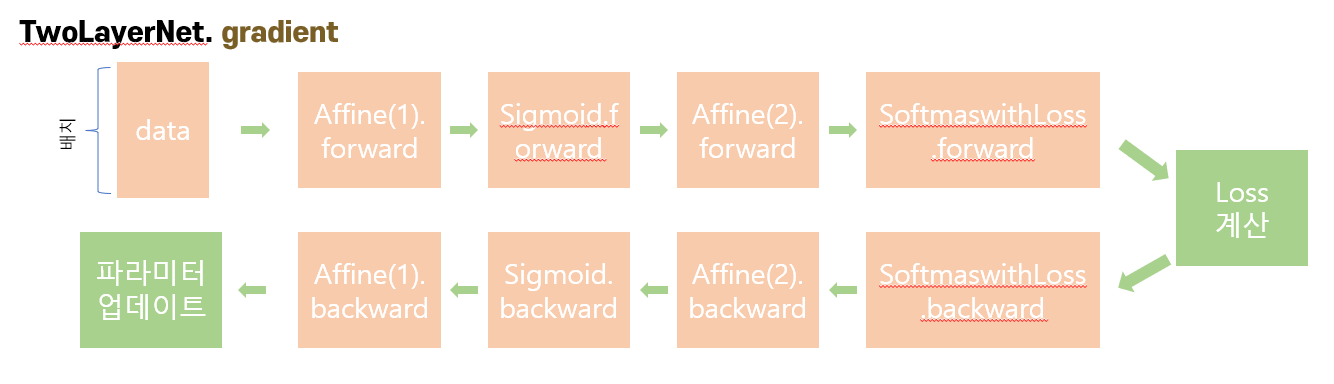

In [14]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, lr=0.01):
        i, h, o = input_size, hidden_size, output_size 
        W1 = lr * np.random.randn(i, h)
        b1 = np.zeros(h)
        W2 = lr * np.random.randn(h, o)
        b2 = np.zeros(o)
        self.params = {}
        self.params['W1'] = W1
        self.params['W2'] = W2
        self.params['b1'] = b1
        self.params['b2'] = b2

        self.layers = [Affine(self.params['W1'], self.params['b1']), 
                       Sigmoid(), 
                       Affine(self.params['W2'], self.params['b2'])]
        self.output_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
        
    def loss(self, x, t):
        y_pred = self.predict(x)
        loss = self.output_layer.forward(y_pred, t)
        return loss
        
    def accuracy(self, x, t):
        y_pred = self.predict(x)
        y_pred = np.argmax(y_pred, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y_pred == t) / float(len(t))
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        #순전파
        self.loss(x, t)

        #역전파
        dout = 1
        dout = self.output_layer.backward(dout)
        
        backLayer = self.layers
        backLayer.reverse()
        for layer in backLayer:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers[2].dW
        grads['b1'] = self.layers[2].db
        grads['W2'] = self.layers[0].dW
        grads['b2'] = self.layers[0].db
        self.layers.reverse()
        return grads

In [29]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
iris = load_iris()
x, y = iris.data, iris.target
y = pd.get_dummies(y)
y = np.array(y)

sclar = StandardScaler()
x = sclar.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.shape, y_train.shape

((120, 4), (120, 3))

In [30]:
#수치미분 기울기 vs 오차역전파 기울기
model = TwoLayerNet(input_size=4, hidden_size=3, output_size=3)

x_batch = x_train[:3]
y_batch = y_train[:3]

grad_numerical = model.numerical_gradient(x_batch, y_batch)
grad_backwrad = model.gradient(x_batch, y_batch)

for key in grad_numerical.keys():
    error = np.average(np.abs(grad_numerical[key] - grad_backwrad[key]))
    print("{} : {}".format(key, error))

W1 : 3.591629506983957e-10
W2 : 4.661758679095374e-10
b1 : 6.916288207295743e-12
b2 : 9.207663890601717e-10


In [31]:
iters_num = 1000
batch_size = 30
data_size = len(x_train)
learning_rate = 0.1

model = TwoLayerNet(input_size=4, hidden_size=3, output_size=3, lr=0.01)

max_iters = data_size // batch_size

train_loss_list = []
train_acc_list = []
test_acc_list = []
w1_list = []
w2_list = []
iter_per_epoch = max(data_size / batch_size, 1)
for i in range(iters_num):
    batch_mask = np.random.choice(data_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = model.gradient(x_batch, y_batch)

    for key in model.params.keys():
        model.params[key] -= learning_rate * grad[key]
    loss = model.loss(x_batch, y_batch)
    train_loss_list.append(loss)
    w1_list.append(model.params["W1"].flatten().tolist())
    w2_list.append(model.params["W2"].flatten().tolist())

    if i % iter_per_epoch == 0:
        train_acc = model.accuracy(x_train, y_train)
        test_acc = model.accuracy(x_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train : {:.2f} test : {:.2f}".format(train_acc, test_acc))
           

train : 0.33 test : 0.37
train : 0.33 test : 0.37
train : 0.33 test : 0.37
train : 0.33 test : 0.37
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.33 test : 0.33
train : 0.33 test : 0.33
train : 0.34 test : 0.30
train : 0.33 test : 0.37
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.33 test : 0.33
train : 0.33 test : 0.33
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.67 test : 0.63
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.34 test : 0.30
train : 0.42 test : 0.40
train : 0.33 test : 0.33
train : 0.66 test : 0.63
train : 0.41 test : 0.37
train : 0.68 test : 0.63
train : 0.66 test : 0.63
train : 0.42 test : 0.37
train : 0.65 test : 0.63
train : 0.55 test : 0.53
train : 0.68 test : 0.63
train : 0.55 test : 0.53


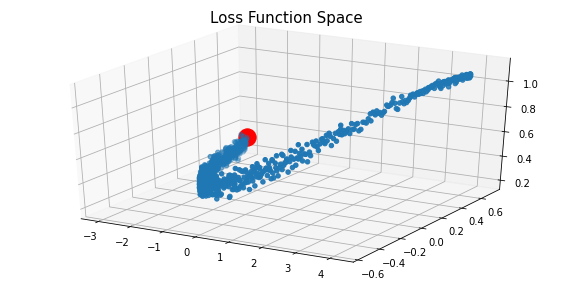

In [32]:
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA

w1_list = np.array(w1_list)
w2_list = np.array(w2_list)
w_list = np.concatenate((w1_list, w2_list), axis=1)

pca = PCA(n_components=2)
W_PCA = pca.fit_transform(w_list)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d') 
ax.scatter(W_PCA[:, 0], W_PCA[:, 1], train_loss_list, s=20)
ax.scatter(W_PCA[-1, 0], W_PCA[-1, 1], train_loss_list[-1], s=300, c='red')
plt.title("Loss Function Space", fontsize=15)
plt.show()

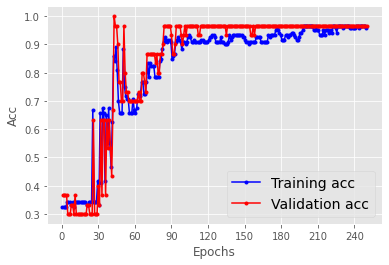

In [33]:
with plt.style.context('ggplot'):
    plot_acc_curves(train_acc_list, test_acc_list)
    plt.show()

In [23]:
os.chdir(r"/content/")
! git clone https://github.com/oreilly-japan/deep-learning-from-scratch.git

Cloning into 'deep-learning-from-scratch'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 457 (delta 0), reused 1 (delta 0), pack-reused 453
Receiving objects: 100% (457/457), 5.52 MiB | 29.44 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [35]:
os.chdir(r"/content/deep-learning-from-scratch/")
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [37]:
import time
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10, lr=0.01)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

st = time.time()
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        print("*"*100)
        print("time %s min"%((time.time() - st) / 60))
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc : {0:.2f}".format(train_acc))
        print("test acc : {0:.2f}".format(test_acc))
        st = time.time()

****************************************************************************************************
time 0.00017891327540079752 min
train acc : 0.12
test acc : 0.12
****************************************************************************************************
time 0.03986899852752686 min
train acc : 0.70
test acc : 0.71
****************************************************************************************************
time 0.03909147580464681 min
train acc : 0.78
test acc : 0.79
****************************************************************************************************
time 0.039479605356852215 min
train acc : 0.81
test acc : 0.82
****************************************************************************************************
time 0.03928916056950887 min
train acc : 0.83
test acc : 0.84
****************************************************************************************************
time 0.03950080871582031 min
train acc : 0.85
test acc : 0.85
******************

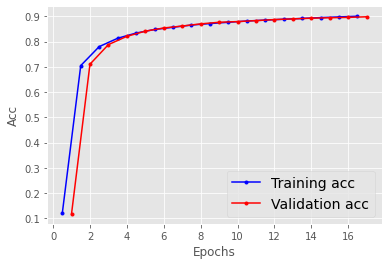

In [38]:
with plt.style.context('ggplot'):
    plot_acc_curves(train_acc_list, test_acc_list)
    plt.show()